# Memory access - naive `matmul!`

https://github.com/mitmath/18S096/blob/master/lectures/lecture4/memory.pdf
https://github.com/mitmath/18S096/blob/master/lectures/lecture4/memory-matrices.ipynb

In [40]:
import Hwloc
topology = Hwloc.topology_load()
println("Machine topology:")
print(topology)

Machine topology:
D0: L0 P0 Machine  
    D1: L0 P-1 Package  
        D2: L0 P-1 L3Cache  Cache{size=6291456,depth=3,linesize=64,associativity=12,type=Unified}
            D3: L0 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L0 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=8,type=Data}
                    D5: L0 P-1 Core  
                        D6: L0 P0 PU  
            D3: L1 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L1 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=8,type=Data}
                    D5: L1 P-1 Core  
                        D6: L1 P1 PU  
            D3: L2 P-1 L2Cache  Cache{size=262144,depth=2,linesize=64,associativity=4,type=Unified}
                D4: L2 P-1 L1Cache  Cache{size=32768,depth=1,linesize=64,associativity=8,type=Data}
                    D5: L2 P-1 Core  
                        D6: L2 P2 PU  
        

In [57]:
# compute C = A * B, using naive matrix-multiplication algorithm,
# with a pre-allocated output array C.
function matmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    for i = 1:m
        for k = 1:p
            c = zero(eltype(C))
            for j = 1:n
                @inbounds c += A[i,j] * B[j,k]
            end
            @inbounds C[i,k] = c
        end
    end
    return C
end

# a wrapper that allocates C of an appropriate type
matmul(A, B) = matmul!(Matrix{promote_type(eltype(A), eltype(B))}(undef, size(A,1), size(B,2)), A, B)

matmul (generic function with 1 method)

In [62]:
# correctness check:
using LinearAlgebra
A = rand(5,6)
B = rand(6,7)
norm(matmul(A,B) - A * B)

5.978733960281817e-16

In [63]:
# for benchmarking, use only single-threaded BLAS:
BLAS.set_num_threads(1)

In [144]:
using BenchmarkTools
N = round.(Int, exp10.(range(1, log10(3000), length=100)))  # 100 sizes from 10 to 3000
# N = round.(Int, exp10.(range(1, log10(3000), length=60)))  # 60 sizes from 10 to 3000
# alternatively, use N = 10:1000 to see some interesting patterns due to cache associativity etc.
t = Float64[]
t0 = Float64[]
@time for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(t, @belapsed matmul!($C,$A,$B))
    push!(t0, @belapsed mul!($C,$A,$B))
    println("finished n = $n: slowdown of ", t[end]/t0[end])
end

finished n = 10: slowdown of 1.6333184748582892
finished n = 11: slowdown of 1.7968822102425877
finished n = 11: slowdown of 1.7910174982053126
finished n = 12: slowdown of 2.5272579981141847
finished n = 13: slowdown of 2.5117196056955096
finished n = 13: slowdown of 2.452501125149563
finished n = 14: slowdown of 2.8898533333333334
finished n = 15: slowdown of 2.836651643192488
finished n = 16: slowdown of 4.585308641975309
finished n = 17: slowdown of 3.9770139330928633
finished n = 18: slowdown of 4.638402625820569
finished n = 19: slowdown of 3.9824865571134227
finished n = 20: slowdown of 5.287934022590091
finished n = 21: slowdown of 4.940917343810459
finished n = 22: slowdown of 5.411764705882353
finished n = 24: slowdown of 6.404441294590124
finished n = 25: slowdown of 5.687230451903244
finished n = 27: slowdown of 5.726791443850267
finished n = 28: slowdown of 6.979702970297029
finished n = 30: slowdown of 6.922988161887261
finished n = 32: slowdown of 8.035676018889639
finis

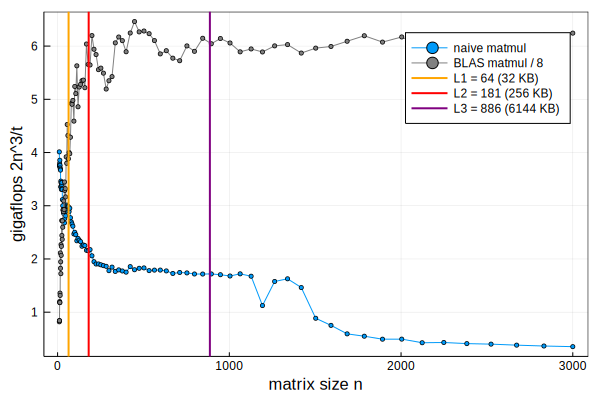

In [153]:
using Plots
plot(N, 2N.^3 ./ t * 1e-9, marker=:circle, label="naive matmul", frame=:box, ms=2)
plot!(N, 2N.^3 ./ t0 * 1e-9 / 8, color=:grey, marker=:circle, label="BLAS matmul / 8", ms=2)
ylabel!("gigaflops 2n^3/t")
xlabel!("matrix size n")

L1 = 32 * 1024
L2 = 256 * 1024
L3 = 6144 * 1024
nL1 = sqrt(L1 / sizeof(Float64))
nL2 = sqrt(L2 / sizeof(Float64))
nL3 = sqrt(L3 / sizeof(Float64))
vline!([nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) (32 KB)")
vline!([nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) (256 KB)")
vline!([nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) (6144 KB)")